# Week 2 - Ungraded Lab: A journey through Data

Welcome to the ungraded lab for week 2 of Machine Learning Engineering for Production. **The paradigm behind Deep Learning is now facing a shift from model-centric to data-centric.** In this lab you will see how data intricacies affect the outcome of your models. To show you how far it will take you to apply data changes without addressing the model, you will be using a single model throughout: a simple Convolutional Neural Network (CNN). While training this model the journey will take you to address common problems: class imbalance and overfitting. As you navigate these issues, the lab will walk you through useful diagnosis tools and methods to mitigate these common problems.

-------
-------

### **IMPORTANT NOTES BEFORE STARTING THE LAB**

Once opened in Colab, click on the "Connect" button on the upper right side corner of the screen to connect to a runtime to run this lab.


**NOTE 1:**

For this lab you get the option to either train the models yourself (this takes around 20 minutes with GPU enabled for each model) or to use pretrained versions which are already provided. There are a total of 3 CNNs that require training and although some parameters have been tuned to provide a faster training time (such as `steps_per_epoch` and `validation_steps` which have been heavily lowered) this may result in a long time spent running this lab rather than thinking about what you observe.

To speed things up we have provided saved pre-trained versions of each model along with their respective training history. We recommend you use these pre-trained versions to save time. However we also consider that training a model is an important learning experience especially if you haven't done this before. **If you want to perform this training by yourself, the code for replicating the training is provided as well. In this case the GPU is absolutely necessary, so be sure that it is enabled.**

To make sure your runtime is GPU you can go to Runtime -> Change runtime type -> Select GPU from the menu and then press SAVE

- Note: Restarting the runtime may
be required.

- Colab will tell you if restarting is necessary -- you can do this from Runtime -> Restart Runtime option in the dropdown.

**If you decide to use the pretrained versions make sure you are not using a GPU as it is not required and may prevent other users from getting access to one.** To check this, go to Runtime -> Change runtime type -> Select None from the menu and then press SAVE.

**NOTE 2:**

Colab **does not** guarantee access to a GPU. This depends on the availability of these resources. However **it is not very common to be denied GPU access**. If this happens to you, you can still run this lab without training the models yourself. If you really want to do the training but are denied a GPU, try switching the runtime to a GPU after a couple of hours.

To know more about Colab's policies check out this [FAQ](https://research.google.com/colaboratory/faq.html).

-----------
-----------

Let's get started!

In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

Before you move on, download the two datasets used in the lab, as well as the pretrained models and histories:

In [2]:
# Download datasets

# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Download pretrained models and training histories
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2021-06-02 17:27:50--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   138MB/s    in 5.5s    

2021-06-02 17:27:55 (143 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2021-06-02 17:27:55--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1259479

## A story of data

To guide you through this lab we have prepared a narrative that simulates a real life scenario:

Suppose you have been tasked to create a model that classifies images of cats, dogs and birds. For this you settle on a simple CNN architecture, since CNN's are known to perform well for image classification. You are probably familiar with two widely used datasets: `cats vs dogs`, and `caltech birds`. As a side note both datasets are available through `Tensforflow Datasets (TFDS)`. However, you decide NOT to use `TFDS` since the lab requires you to modify the data and combine the two datasets into one. 

## Combining the datasets

The raw images in these datasets can be found within the following paths:


In [3]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

The next step is extracting the data into a directory of choice, `base_dir` in this case.

Note that the `cats vs dogs` images are in `zip` file format while the `caltech birds` images come in a `tar` file.

In [4]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [5]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

For the cats and dogs images no further preprocessing is needed as all exemplars of a single class are located in one directory: `PetImages\Cat` and `PetImages\Dog` respectively. Let's check how many images are available for each category:

In [6]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


The Bird images dataset organization is quite different. This dataset is commonly used to classify species of birds so there is a directory for each species. Let's treat all species of birds as a single class. This requires moving all bird images to a single directory (`PetImages/Bird` will be used for consistency). This can be done by running the next cell:

In [7]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


It turns out that there is a similar number of images for each class you are trying to predict! Nice!

Let's take a quick look at an image of each class you are trying to predict.

Sample cat image:


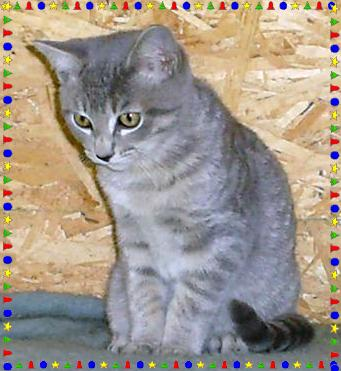


Sample dog image:


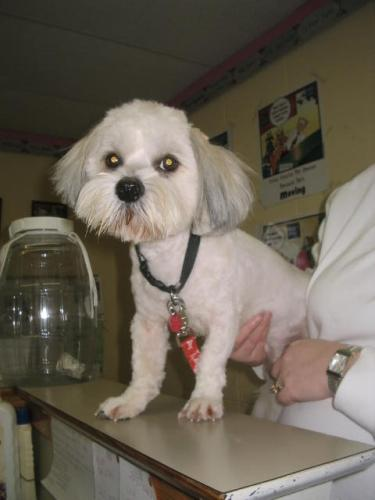


Sample bird image:


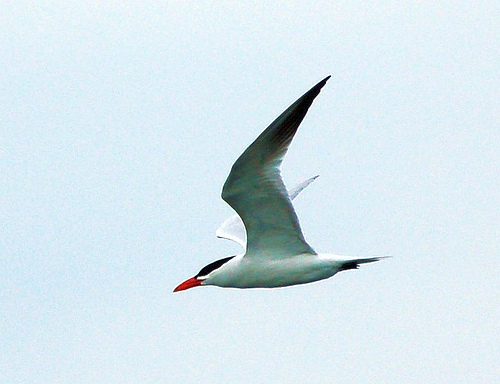

In [8]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

## Train / Evaluate Split

Before training the model you need to split the data into `training` and `evaluating` sets. For training, we have chosen the [`Keras`](https://keras.io) application programming interface (API) which includes functionality to read images from  various directories. The easier way to split the data is to create a different directory for each split of each class.

Run the next cell to create the directories for training and evaluating sets.

In [10]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

Now, let's define a function that will move a percentage of images from an origin folder to a destination folder as desired to generate the training and evaluation splits:

In [11]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

And now you are ready to call the previous function and split the data:

In [12]:
# Move 70% of the images to the train dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# Move the remaining images to the eval dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

Something important to mention is that as it currently stands your dataset has some issues that will prevent model training and evaluation. Mainly:

1. Some images are corrupted and have zero bytes.
2. Cats vs dogs zip file included a `.db` file for each class that needs to be deleted.

If you didn't fix this before training you will get errors regarding these issues and training will fail. Zero-byte images are not valid images and Keras will let you know once these files are reached. In a similar way `.db` files are not valid images. **It is a good practice to always make sure that you are submitting files with the correct specifications to your training algorithm before start running it** as these issues might not be encountered right away and you will have to solve them and start training again.

Running the following `bash` commands in the base directory will resolve these issues:

In [13]:
!find /tmp/data/ -size 0 -exec rm {} +
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

The first command removes all zero-byte files from the filesystem. The second one removes any file that does not have a `.jpg` extension. 

This also serves as a reminder of the power of bash. Although you could achieve the same result with Python code, bash allows you to do this much quicker. If you are not familiar with bash or some other shell-like language we encourage you to learn some of it as it is a very useful tool for data manipulation purposes.

Let's check how many images you have available for each split and class after you remove the corrupted images:

In [14]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


It turns out that very few files presented the issues mentioned above. That's good news but it is also a reminder that small problems with the dataset might unexpectedly affect the training process. In this case, 4 non valid image files will have prevented you from training the model. 

In most cases training Deep Learning models is a time intensive task, so be sure to have everything in place before starting this process.


## An unexpected issue!

Let's face the first real life issue in this narrative! There was a power outage in your office and some hard drives were damaged and as a result of that, many of the images for `dogs` and `birds` have been erased. As a matter of fact, only 20% of the dog images and 10% of the bird images survived.

To simulate this scenario, let's quickly create a new directory called `imbalanced` and copy only the proportions mentioned above for each class.

In [15]:
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, 'imbalanced/'+dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/'+dir))

In [16]:
# Very similar to the one used before but this one copies instead of moving
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

# Perform the copying
copy_with_limit(os.path.join(base_dir, 'train/cats'), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'train/dogs'), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'train/birds'), os.path.join(base_dir, 'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, 'eval/cats'), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'eval/dogs'), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'eval/birds'), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)

# Print number of available images
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


For now there is no quick or clear solution to the accidental file loss. So you decide to keep going and train the model with the remaining images.

## Selecting the model

Let's go ahead and create a model architecture and define a loss function, optimizer and performance metrics leveraging keras API:

In [17]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # A simple CNN architecture based on the one found here: https://www.tensorflow.org/tutorials/images/classification
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

And let's print out a model summary as a quick check.

In [18]:
# Create a model to use with the imbalanced dataset
imbalanced_model = create_model()

# Print the model's summary
print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

For training the model you will be using Keras' ImageDataGenerator, which has built-in functionalities to easily feed your model with raw, rescaled or even augmented image data.

Another cool functionality within ImageDataGenerator is the `flow_from_directory` method which allows to read images as needed from a root directory. This method needs the following arguments:

- `directory`: Path to the root directory where the images are stored.
- `target_size`: The dimensions to which all images found will be resized. Since images come in all kinds of resolutions, you need to standardize their size. 150x150 is used but other values should work well too.
- `batch_size`: Number of images the generator yields everytime it is asked for a next batch. 32 is used here.
- `class_mode`: How the labels are represented. Here "binary" is used to indicate that labels will be 1D. This is done for compatibility with the loss and evaluation metrics used when compiling the model.

If you want to learn more about using Keras' ImageDataGenerator, check this [tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/imbalanced/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/imbalanced/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


Let's do a quick sanity check to inspect that both generators (training and validation) use the same labels for each class:

In [20]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}



# Training a CNN with class imbalanced data


In [21]:
# Load pretrained model and history

imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
imbalanced_model = tf.keras.models.load_model('model-imbalanced')

In [ ]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# imbalanced_history = imbalanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

To analyze the model performance properly, it is important to track different metrics such as accuracy and loss function along the training process. Let's define a helper function to handle the metrics through the training history,depending on the method you previously selected:

In [22]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

Now, let's plot the metrics and losses for each training epoch as the training process progresses. 

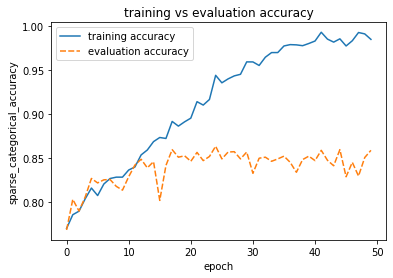

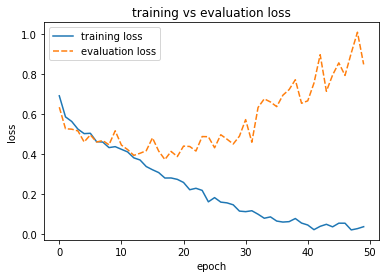

In [23]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()



plot_train_eval(imbalanced_history)

From these two plots is quite evident that the model is overfitting the training data. However, the evaluation accuracy is still pretty high. Maybe class imbalance is not such a big issue after all. Perhaps this is too good to be true. 

Let's dive a little deeper, and compute some additional metrics to explore if the class imbalance is hampering the model to perform well. In particular, let's compare: the accuracy score,  the accuracy score balanced, and the confusion matrix.  Information on the accuracy scores calculations is provided in the [sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) documentation. To refresh ideas on what is a confusion matrix check [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix).

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [25]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 4852 images belonging to 3 classes.


In [26]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

Accuracy Score: 0.855111294311624
Balanced Accuracy Score: 0.7417486453422518


Comparing the `accuracy` and `balanced accuracy` metrics, the class imbalance starts to become apparent. Now let's compute the `confusion matrix` of the predictions. Notice that the class imbalance is also present in the evaluation set so the confusion matrix will show an overwhelming majority for cats.

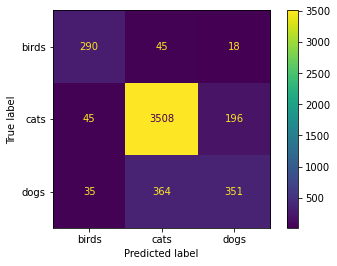

In [27]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [28]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 21.62%
Proportion of misclassified cats: 10.44%
Proportion of misclassified dogs: 37.88%


Class imbalance is a real problem that if not detected early on, gives the wrong impression that your model is performing better than it actually is. For this reason,  is important to rely on several metrics that do a better job at capturing these kinds of issues. **In this case the standard `accuracy` metric is misleading** and provides a false sense that the model is performing better than it actually is.

To prove this point further consider a model that only predicts cats:

In [29]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.7726710634789777
Balanced Accuracy Score: 0.3333333333333333


If you only look at the `accuracy` metric the model seems to be working fairly well, since the majority class is the same that the model always predicts.

There are several techniques to deal with class imbalance. A very popular one is `SMOTE`, which oversamples the minority classes by creating syntethic data. However, these techniques are outside the scope of this lab.

The previous metrics were computed with class imbalance both on the training and evaluation sets. If you are wondering how the model performed with class imbalance only on the training set run the following cell to see the confusion matrix with balanced classes in the evaluation set:


Found 11036 images belonging to 3 classes.


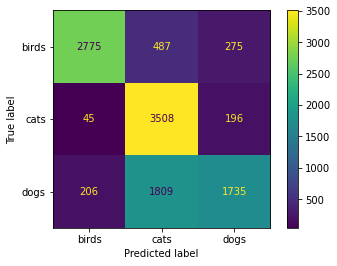

In [30]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

# Training with the complete dataset

For the time being and following the narrative, assume that a colleague of yours was careful enough to save a backup of the complete dataset in her cloud storage. Now you can try training without the class imbalance issue, what a relief!

Now that you have the complete dataset it is time to try again without suffering from class imbalance. **In general, collecting more data is beneficial for models!**

In [31]:
# Create a model to use with the balanced dataset
balanced_model = create_model()

In [32]:
# Still no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [33]:
# Load pretrained model and history

balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [ ]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# balanced_history = balanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

Let's check how the `accuracy` vs `balanced accuracy` comparison looks like now:

In [34]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [35]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8636281261326567
Balanced Accuracy Score: 0.8647221799730266


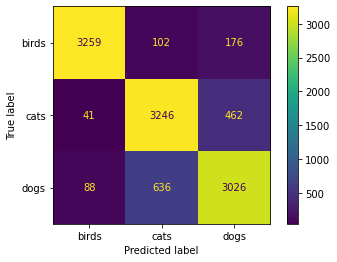

In [38]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

Both accuracy-based metrics are very similar now. The confusion matrix also looks way better than before. This suggests that class imbalance has been successfully mitigated by adding more data to the previously undersampled classes.

Now that you now that you can trust the `accuracy` metric, let's plot the training history:

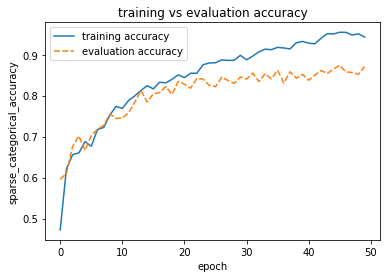

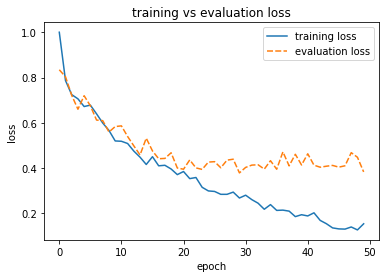

In [37]:
plot_train_eval(balanced_history)

This looks much better than for the imbalanced case! However, overfitting is still present.

Can you think of ways to address this issue? If you are familiar with CNN's you might think of adding `dropout` layers. This intuition is correct but for the time being you decide to stick with the same model and only change the data to see if it is possible to mitigate overfitting in this manner.

Another possible solution is to apply data augmentation techniques. Your whole team agrees this is the way to go so you decide to try this next!

# Training with Data Augmentation

Augmenting images is a technique in which you create new versions of the images you have at hand, by applying geometric transformations. These transformations can vary from: zooming in and out, rotating, or even flipping the images. By doing this, you get a training dataset that exposes the model to a wider variety of images. This helps in further exploring the feature space and hence reducing the chances of overfitting. 

It is also a very natural idea since doing slight (or sometimes not so slight) changes to an image will result in an equally valid image. A cat sitting in an awkward position is still a cat, right?

In [39]:
# Create a model to use with the balanced and augmented dataset
augmented_model = create_model()

In [40]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


Notice that the only difference with the previous training is that the `ImageDataGenerator` object now has some extra parameters. We encourage you to read more about this topic [here](https://keras.io/api/preprocessing/image/) if you haven't already. Also **this was only done to the training generator since this technique should only be applied to the training images.**


But what exactly are these extra parameters doing? 

Let's see these transformations in action. The following cell applies and displays different transformations for a single image:


Transformation number: 0



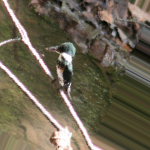


Transformation number: 1



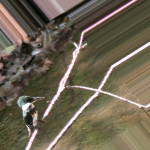


Transformation number: 2



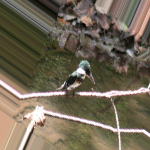


Transformation number: 3



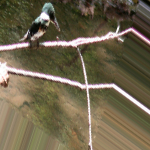

In [41]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in the training partition
def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)

Let's look at another more extreme example:


Transformation number: 0



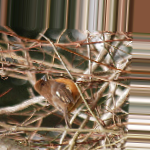


Transformation number: 1



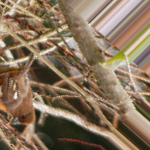


Transformation number: 2



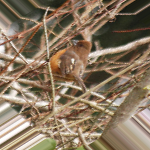


Transformation number: 3



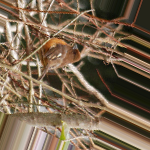

In [42]:
# An ImageDataGenerator with more extreme data augmentation
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

Feel free to try your own custom ImageDataGenerators! The results can be very fun to watch. If you check the [docs](https://keras.io/api/preprocessing/image/) there are some other parameters you may want to toy with.

Now that you know what data augmentation is doing to the training images let's move onto training:

In [43]:
# Load pretrained model and history

augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

In [ ]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# augmented_history = augmented_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=80,
#     validation_data=validation_generator,
#     validation_steps=80)

Since you know that class imbalance is no longer an issue there is no need to check for more in-depth metrics. 

Let's plot the training history right away:

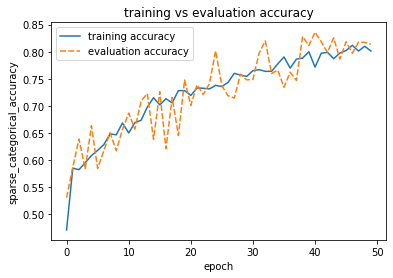

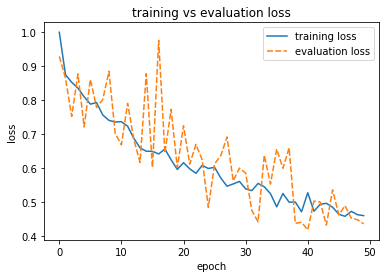

In [44]:
plot_train_eval(augmented_history)

Now, the evaluation accuracy follows more closely the training one. This indicates that **the model is no longer overfitting**. Quite a remarkable finding, achieved by just augmenting the data set. Another option to handle overfitting is to include dropout layers in your model as mentioned earlier.

Another point worth mentioning, is that this model achieves a slightly lower evaluation accuracy when compared to the model without data augmentation. The reason for this, is that this model needs more epochs to train. To spot this issue, check that for the model without data augmentation, the training accuracy reached almost 100%, whereas the augmented one can still improve. 


## Wrapping it up

**Congratulations on finishing this ungraded lab!** 

It is quite amazing to see how data alone can impact Deep Learning models. Hopefully this lab helped you have a better understanding of the importance of data. 

In particular, you figured out ways to diagnose the effects of class imbalance and looked at specific metrics to spot this problem. Adding more data is a simple way to overcome class imbalance. However, this is not always feasible in a real life scenario.

In the final section, you applied multiple geometric transformations to the images in the training dataset, to generate an augmented version. The goal was to use data augmentation to reduce overfitting. Changing the network architecture is an alternative method to reduce overfitting. In practice, it is a good idea to implement both techniques for better results.


**Keep it up!**